## Import Package

In [80]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
from PIL import Image
#import helper

%matplotlib inline
%config IPCompleter.greedy=True

In [81]:
# necessary imports
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

## Import data for model training

In [83]:
## Specify appropriate transforms, and batch_sizes
valid_transforms = transforms.Compose([transforms.Resize((50, 50)),
                                    # transforms.CenterCrop(160),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                        [0.229, 0.224, 0.225])])

data_dir = '/home/workspace/mortgage_face_real'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# define datasets
train_datasets = datasets.ImageFolder(train_dir, transform=valid_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform=valid_transforms)

# define data loaders
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_datasets, batch_size=32)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=32)

loaders_scratch = dict()
loaders_scratch['train'] = trainloader
loaders_scratch['valid'] = validloader
loaders_scratch['test'] = testloader

## Model Architecture

In [84]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [85]:
import torch.nn as nn
from collections import OrderedDict

for param in VGG16.parameters():
    param.requires_grad = False
    
drop_p = 0.1   

classifier_dict = [('fc1', nn.Linear(512, 128)),
                    ('relu1', nn.ReLU()),
                    ('drop1', nn.Dropout(p=drop_p)),
                    ('fc2', nn.Linear(128, 16)),
                    ('relu2', nn.ReLU()),
                    ('drop2', nn.Dropout(p=drop_p)),
                    ('fc3', nn.Linear(16, 2)),
                    #('output', nn.LogSoftmax(dim=1))
                  ]

classifier = nn.Sequential(OrderedDict(classifier_dict))
    
VGG16.classifier = classifier

if use_cuda:
    VGG16 = VGG16.cuda()

In [86]:
loan_detection_model = VGG16

In [87]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(loan_detection_model.classifier.parameters(), lr=0.001)

In [88]:
def weights_init(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

## Model Training

In [89]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            
            loss = criterion(output, target)
            valid_loss += (1 / (batch_idx + 1)) * (loss.data - valid_loss)

        
        if epoch % 3 == 1:
            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))

                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
# loan_detection_model = train(90, loaders_scratch, loan_detection_model, optimizer_transfer, 
#                      criterion_transfer, use_cuda, 'loan_detection_model.pt')
loan_detection_model = train(90, loaders_scratch, loan_detection_model, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'loan_detection_model2.pt')

Epoch: 1 	Training Loss: 0.690461 	Validation Loss: 0.678276
Validation loss decreased (inf --> 0.678276).  Saving model ...
Epoch: 4 	Training Loss: 0.680907 	Validation Loss: 0.672813
Validation loss decreased (0.678276 --> 0.672813).  Saving model ...
Epoch: 7 	Training Loss: 0.707830 	Validation Loss: 0.667817
Validation loss decreased (0.672813 --> 0.667817).  Saving model ...
Epoch: 10 	Training Loss: 0.686924 	Validation Loss: 0.662233
Validation loss decreased (0.667817 --> 0.662233).  Saving model ...
Epoch: 13 	Training Loss: 0.674723 	Validation Loss: 0.658576
Validation loss decreased (0.662233 --> 0.658576).  Saving model ...
Epoch: 16 	Training Loss: 0.660586 	Validation Loss: 0.655474
Validation loss decreased (0.658576 --> 0.655474).  Saving model ...
Epoch: 19 	Training Loss: 0.661074 	Validation Loss: 0.650291
Validation loss decreased (0.655474 --> 0.650291).  Saving model ...
Epoch: 22 	Training Loss: 0.639938 	Validation Loss: 0.646778
Validation loss decreased (0.

In [19]:
# load the model that got the best validation accuracy
# loan_detection_model.load_state_dict(torch.load('loan_detection_model.pt'))
loan_detection_model.load_state_dict(torch.load('loan_detection_model2.pt'))

In [90]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, loan_detection_model, criterion_transfer, use_cuda)

Test Loss: 0.831689


Test Accuracy: 61% (21/34)


In [91]:
class_names = [item for item in loaders_scratch['train'].dataset.classes]

def load_image(img_path):    
    img = Image.open(img_path).convert('RGB')
    img_transforms = transforms.Compose([transforms.Resize((50, 50)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406), 
                                                              (0.229, 0.224, 0.225))])

    img = img_transforms(img)[:3,:,:].unsqueeze(0)
    return img

def predict_loan(model, img_path):
    # load the image and return the predicted breed
    img = load_image(img_path)
    
    if use_cuda:
        model, img = model.cuda(), img.cuda()
        
    model.eval()
    
    
    outputs = model(img)
    softmax_result = F.softmax(outputs, dim=1)
    # print(round(torch.max(softmax_result.data, 1)[0].item() * 100, 2))
    
    
    _, predicted = torch.max(outputs.data, 1)
    #idx = torch.argmax(model(img))
    return class_names[predicted], round(torch.max(softmax_result.data, 1)[0].item() * 100, 2)

# testing
img_path = '/home/workspace/mortgage_faces/train/loan/187001.jpg'
print(predict_loan(loan_detection_model, img_path))

('loan', 64.52)


## Test the application with real datasets

Hello!


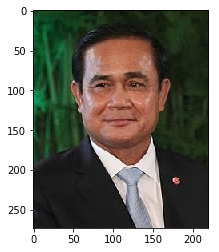

You are going to loan. Confident: 68.81%




In [93]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    print("Hello!")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    loan_flag, confident = predict_loan(loan_detection_model, img_path)
    if loan_flag == 'loan':
        print('You are going to loan. Confident: ' + str(confident) + '%')
    else:
        print('You are not going to loan. Confident: ' + str(confident) + '%')
        
        
    print('\n')

img_path = '/home/workspace/Image/Sample2.jpg'        
run_app(img_path)

## Backup Cells

In [15]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    
    image = Image.open(img_path) #.convert('RGB')
    # size = (224, 224)
    size = (50, 50)
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
        
    output = int(torch.max(VGG16(image), 1)[1][0])
    
    return output # predicted class index


In [16]:
print(VGG16_predict('/home/workspace/processed_celeba_small/celeba/190960.jpg'))

0
